# Tau_m effects on temporal enconding and noise

In [1]:
import pprint
import subprocess
import sys 
sys.path.append('../')

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.9, 12)

np.set_printoptions(suppress=True, precision=5)

sns.set(font_scale=3.5)

from network import Protocol, NetworkManager, BCPNNPerfect, TimedInput
from connectivity_functions import create_orthogonal_canonical_representation, build_network_representation
from connectivity_functions import get_weights_from_probabilities, get_probabilities_from_network_representation
from connectivity_functions import create_matrix_from_sequences_representation, produce_overlaped_sequences
from analysis_functions import calculate_recall_time_quantities, get_weights
from analysis_functions import get_weights_collections
from plotting_functions import plot_network_activity_angle, plot_weight_matrix
from analysis_functions import calculate_angle_from_history, calculate_winning_pattern_from_distances
from analysis_functions import calculate_patterns_timings, calculate_recall_success_nr, calculate_T_persistence

epsilon = 10e-80

## An example

s1=  1.0
T_persistence, 0.101


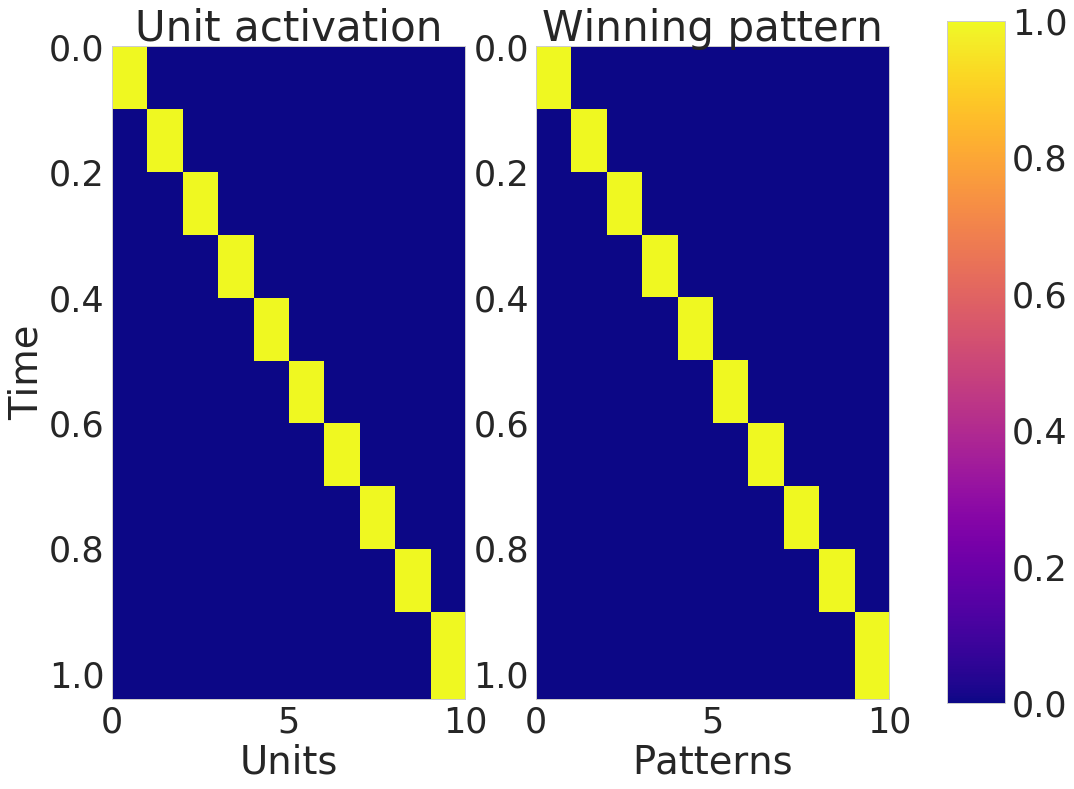

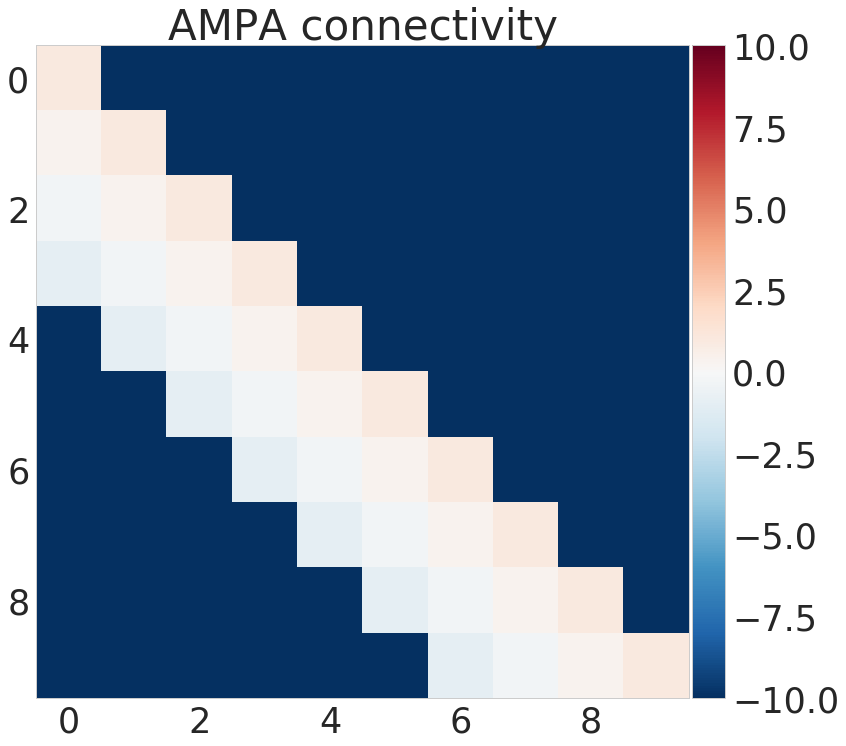

In [2]:
always_learning = False
strict_maximum = True
perfect = True
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
g_beta = 0.0
tau_a = 0.100
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 's', 'i_ampa', 'a']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

# Recall
T_cue = 0.020
T_recall = 1.0 + T_cue
n = 1


# Neural Network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, 
                  g_beta=g_beta, sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, 
                  tau_p=tau_p, z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
seq = matrix[:n_patterns]
nr = build_network_representation(seq, minicolumns, hypercolumns)

n_connections = len(seq) - 1
value = 1.0
extension = 3
T_persistence = 0.100
Bs = [1 - np.exp(-T_persistence / tau_a) for i in range(n_connections)]
alpha = Bs[0]
w_min = -10
weights = [value for i in range(n_connections)]
weights_collection = [weights]
sequences = [seq]
w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                extension, alpha, w_min=w_min)

nn.w_ampa = w
aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
manager.patterns_dic = patterns_dic

aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=0.005)
s, timings, pattern_sequence = aux
times = [t[1] for t in timings[1:n_patterns - 1]]
T_mean = np.mean(times)
print('s1= ', s)
print('T_persistence,', T_mean)
plot_network_activity_angle(manager)
plot_weight_matrix(nn, ampa=True)

## T_persistence limits with tau

In [3]:
always_learning = False
strict_maximum = True
perfect = True
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
g_beta = 0.0
tau_a = 0.100
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.0001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

# Recall
T_cue = 0.020
T_recall = 1.0 + T_cue
n = 1
remove = 0.001


# Neural Network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, 
                  g_beta=g_beta, sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, 
                  tau_p=tau_p, z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
seq = matrix[:n_patterns]
nr = build_network_representation(seq, minicolumns, hypercolumns)

num = 30
T_persistence_vector = np.linspace(remove, 0.100, num=num)
measured_T = np.zeros(num)
measured_T_tau_m = np.zeros(num)

for index, T_persistence in enumerate(T_persistence_vector):
    T_recall = 1.5 * n_patterns * T_persistence + T_cue
    n_connections = len(seq) - 1
    value = 1.0
    extension = 3
    Bs = [1 - np.exp(-T_persistence / tau_a) for i in range(n_connections)]
    alpha = Bs[0]
    w_min = -10
    weights = [value for i in range(n_connections)]
    weights_collection = [weights]
    sequences = [seq]
    w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                    extension, alpha, w_min=w_min)

    nn.w_ampa = w
    aux, indexes = np.unique(nr, axis=0, return_index=True)
    patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
    manager.patterns_dic = patterns_dic

    aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=remove)
    s, timings, pattern_sequence = aux
    times = [t[1] for t in timings[1:n_patterns - 1]]
    T_mean = np.mean(times)
    measured_T[index] = T_mean
    
    
print('Perect Done')
perfect = False

# Neural Network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, 
                  g_beta=g_beta, sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, 
                  tau_p=tau_p, z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
seq = matrix[:n_patterns]
nr = build_network_representation(seq, minicolumns, hypercolumns)

for index, T_persistence in enumerate(T_persistence_vector):
    T_recall = 1.5 * n_patterns * T_persistence + T_cue
    n_connections = len(seq) - 1
    value = 1.0
    extension = 3
    Bs = [1 - np.exp(-T_persistence / tau_a) for i in range(n_connections)]
    alpha = Bs[0]
    w_min = -10
    weights = [value for i in range(n_connections)]
    weights_collection = [weights]
    sequences = [seq]
    w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                    extension, alpha, w_min=w_min)

    nn.w_ampa = w
    aux, indexes = np.unique(nr, axis=0, return_index=True)
    patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
    manager.patterns_dic = patterns_dic

    aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=remove)
    s, timings, pattern_sequence = aux
    times = [t[1] for t in timings[1:n_patterns - 1]]
    T_mean = np.mean(times)
    measured_T_tau_m[index] = T_mean

Perect Done


/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/heberto/miniconda/envs/python3/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


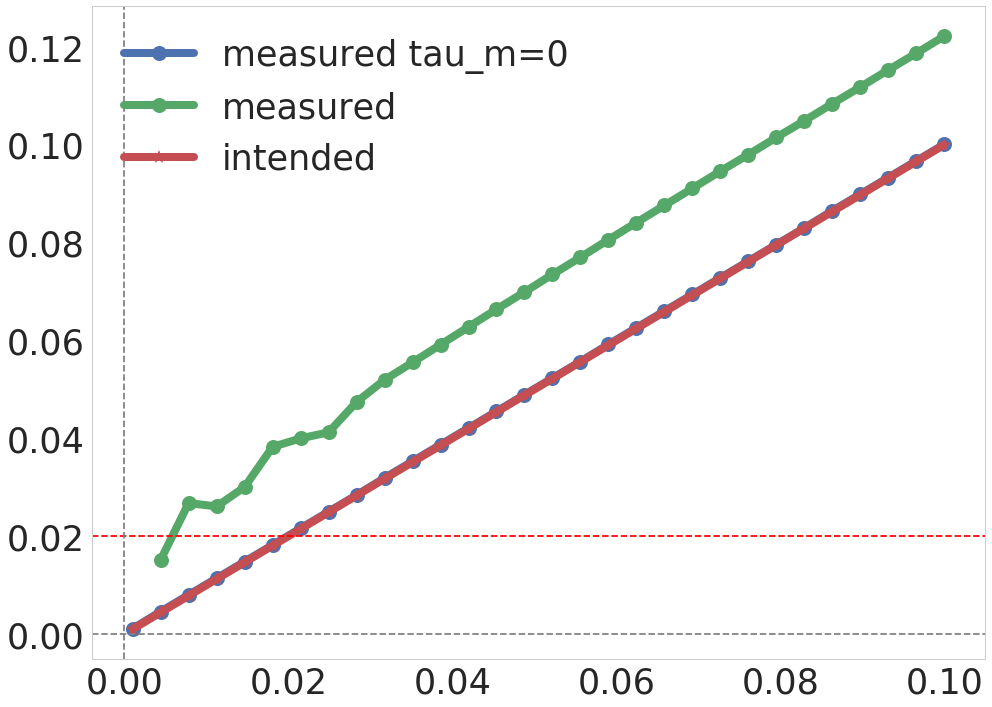

In [4]:
ms = 15
lw = 8

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(T_persistence_vector, measured_T, 'o-', ms=ms, lw=lw, label='measured tau_m=0')
ax.plot(T_persistence_vector, measured_T_tau_m, 'o-', ms=ms, lw=lw, label='measured')
ax.plot(T_persistence_vector, T_persistence_vector, '*-',
        ms=ms, lw=lw, label='intended')

ax.legend()
ax.axhline(tau_m, ls='--', color='red')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')

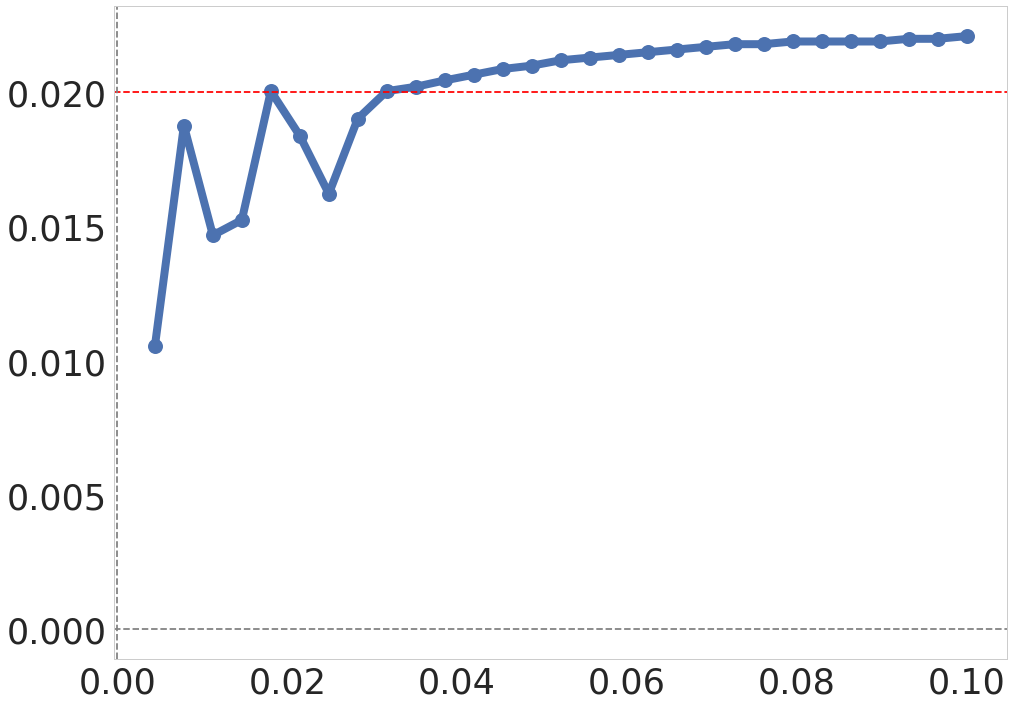

In [5]:
ms = 15
lw = 8

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(T_persistence_vector, measured_T_tau_m - measured_T, 'o-', ms=ms, lw=lw)

ax.axhline(tau_m, ls='--', color='red')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray');

As I can see, the minimum tau_m seems like around 20ms. 
Is also not suprising that the we can encode the vector for the perfect integrator case when the system is indeed a perfect integrator. 

This whole analysis was mean as a proof that I could estimate the non-perfect inegrator case by adding tau_m. NOW THERE IS A BETTER way

## Tau_a effects (not found)

In [6]:
%%time

always_learning = False
strict_maximum = True
perfect = True
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
g_beta = 0.0
tau_a = 0.100
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.0001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

# Recall
T_cue = 0.020
T_recall = 1.0 + T_cue
n = 1
remove = 0.001

num = 30
T_persistence_vector = np.linspace(0.020, 0.100, num=num)
measured_T_list = []
measured_T_tau_m_list = []
tau_a_list = [0.050, 0.100, 0.150, 0.250]


for tau_a in tau_a_list:
    print(tau_a)
    measured_T = np.zeros(num)
    measured_T_tau_m = np.zeros(num)
    # Neural Network
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, 
                      g_beta=g_beta, sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, 
                      tau_p=tau_p, z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Protocol
    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
    seq = matrix[:n_patterns]
    nr = build_network_representation(seq, minicolumns, hypercolumns)
    
    nn.perfect = True
    for index, T_persistence in enumerate(T_persistence_vector):
        T_recall = 1.5 * n_patterns * T_persistence + T_cue
        n_connections = len(seq) - 1
        value = 1.0
        extension = 3
        Bs = [1 - np.exp(-T_persistence / tau_a) for i in range(n_connections)]
        alpha = Bs[0]
        w_min = -10
        weights = [value for i in range(n_connections)]
        weights_collection = [weights]
        sequences = [seq]
        w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                        extension, alpha, w_min=w_min)

        nn.w_ampa = w
        aux, indexes = np.unique(nr, axis=0, return_index=True)
        patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
        manager.patterns_dic = patterns_dic

        aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=remove)
        s, timings, pattern_sequence = aux
        times = [t[1] for t in timings[1:n_patterns - 1]]
        T_mean = np.mean(times)
        measured_T[index] = T_mean

    measured_T_list.append(np.copy(measured_T))
    
    # Neural Network
    nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, 
                      g_beta=g_beta, sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, 
                      tau_p=tau_p, z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                      perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                      normalized_currents=normalized_currents)

    # Build the manager
    manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

    # Protocol
    matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
    seq = matrix[:n_patterns]
    nr = build_network_representation(seq, minicolumns, hypercolumns)
    
    nn.perfect = False
    for index, T_persistence in enumerate(T_persistence_vector):
        T_recall = 1.5 * n_patterns * T_persistence + T_cue
        n_connections = len(seq) - 1
        value = 1.0
        extension = 3
        Bs = [1 - np.exp(-T_persistence / tau_a) for i in range(n_connections)]
        alpha = Bs[0]
        w_min = -10
        weights = [value for i in range(n_connections)]
        weights_collection = [weights]
        sequences = [seq]
        w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                        extension, alpha, w_min=w_min)

        nn.w_ampa = w
        aux, indexes = np.unique(nr, axis=0, return_index=True)
        patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
        manager.patterns_dic = patterns_dic

        aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=remove)
        s, timings, pattern_sequence = aux
        times = [t[1] for t in timings[1:n_patterns - 1]]
        T_mean = np.mean(times)
        measured_T_tau_m[index] = T_mean
    
    measured_T_tau_m_list.append(np.copy(measured_T_tau_m))

0.05
0.1
0.15
0.25
CPU times: user 7min 42s, sys: 488 ms, total: 7min 43s
Wall time: 7min 43s


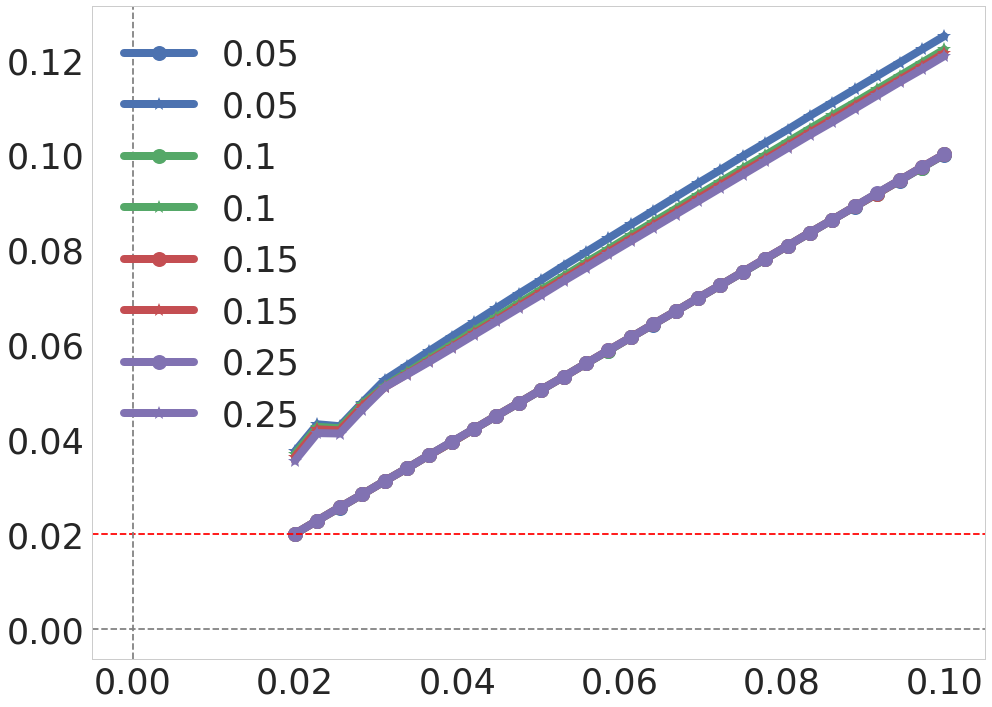

In [7]:
ms = 15
lw = 8

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
colors = sns.color_palette()


for index, tau_a in enumerate(tau_a_list):
    ax.plot(T_persistence_vector, measured_T_list[index], 'o-', color=colors[index], ms=ms, lw=lw,
            label=str(tau_a))
    ax.plot(T_persistence_vector, measured_T_tau_m_list[index], '*-', color=colors[index],
            ms=ms, lw=lw, label=str(tau_a))

ax.axhline(tau_m, ls='--', color='red')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')
ax.legend();

What we see here is the difference between the enconded Persistence Time andd the read one with non-perfect integrator. The difference is around 20ms more or less independent of the effect of tau_a. In the next plot we show the difference.

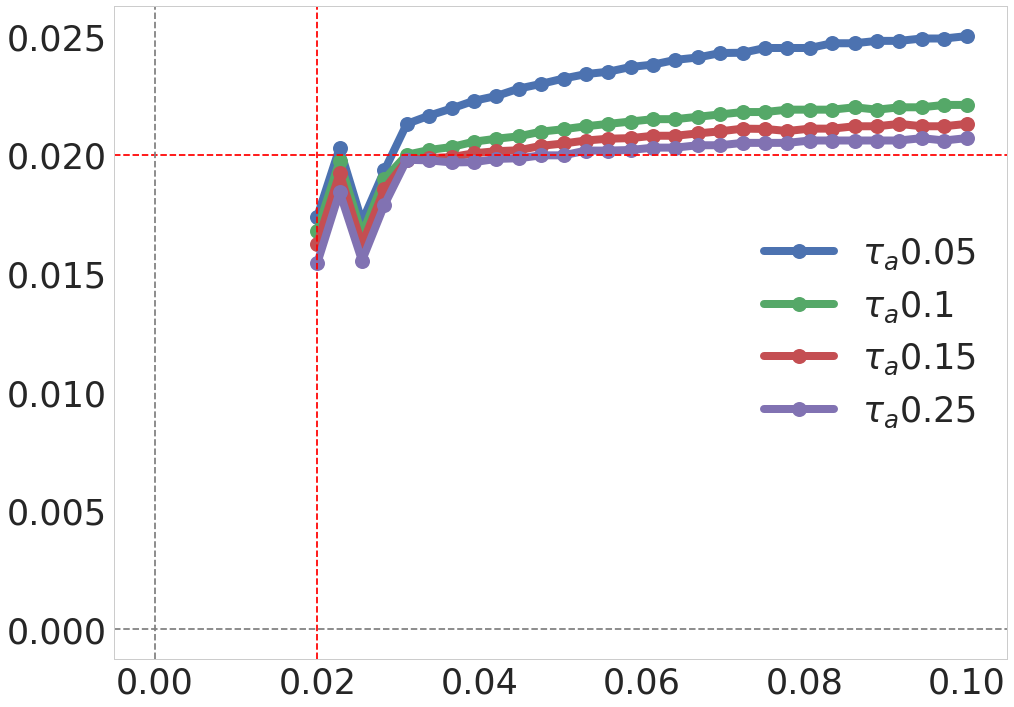

In [8]:
ms = 15
lw = 8

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
colors = sns.color_palette()


for index, tau_a in enumerate(tau_a_list):
    ax.plot(T_persistence_vector, measured_T_tau_m_list[index] - measured_T_list[index], 'o-',
            ms=ms, lw=lw, label=r'$\tau_a$' + str(tau_a))

ax.axhline(tau_m, ls='--', color='red')
ax.axvline(tau_m, ls='--', color='red')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')
ax.legend();

## Enconding and reading with non-perfect integrator formula

In [9]:
%%time

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
g_beta = 0.0
tau_a = 0.100
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.0001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

# Recall
T_cue = 0.020
T_recall = 1.0 + T_cue
n = 1
remove = 0.010

num = 30
T_persistence_vector = np.linspace(0.015, 0.150, num=num)

measured_T = np.zeros(num)
T_theo = np.zeros(num)
success = np.zeros(num)


# Neural Network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, 
                  g_beta=g_beta, sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, 
                  tau_p=tau_p, z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
seq = matrix[:n_patterns]
nr = build_network_representation(seq, minicolumns, hypercolumns)
    

for index, T_persistence in enumerate(T_persistence_vector):
    T_recall = 1.5 * n_patterns * T_persistence + T_cue
    n_connections = len(seq) - 1
    value = 1.0
    extension = 3
    r = tau_m / tau_a
    f = 1 - r
    correction = (r / f) * np.exp(-T_persistence / tau_m)
    B = 1 - (1/f) * np.exp(-T_persistence / tau_a) 
    alpha = B
    w_min = -10
    weights = [value for i in range(n_connections)]
    weights_collection = [weights]
    sequences = [seq]
    w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                    extension, alpha, w_min=w_min)

    nn.w_ampa = w
    aux, indexes = np.unique(nr, axis=0, return_index=True)
    patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
    manager.patterns_dic = patterns_dic

    aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=remove)
    s, timings, pattern_sequence = aux
    times = [t[1] for t in timings[1:n_patterns - 1]]
    if False:
        print('--------')
        print('this', np.exp(-T_persistence / tau_m))
        print('correction', correction)
        print('T_persistence', T_persistence)
        print('alpha', alpha)
        pprint.pprint(times)
    T_mean = np.mean(times)
    measured_T[index] = T_mean
    w_tran = alpha 
    T_theo[index] = calculate_T_persistence(tau_a, g_w_ampa, w_tran, g_a, tau_m, perfect=perfect)
    success[index] = s

CPU times: user 1min 18s, sys: 68 ms, total: 1min 18s
Wall time: 1min 19s


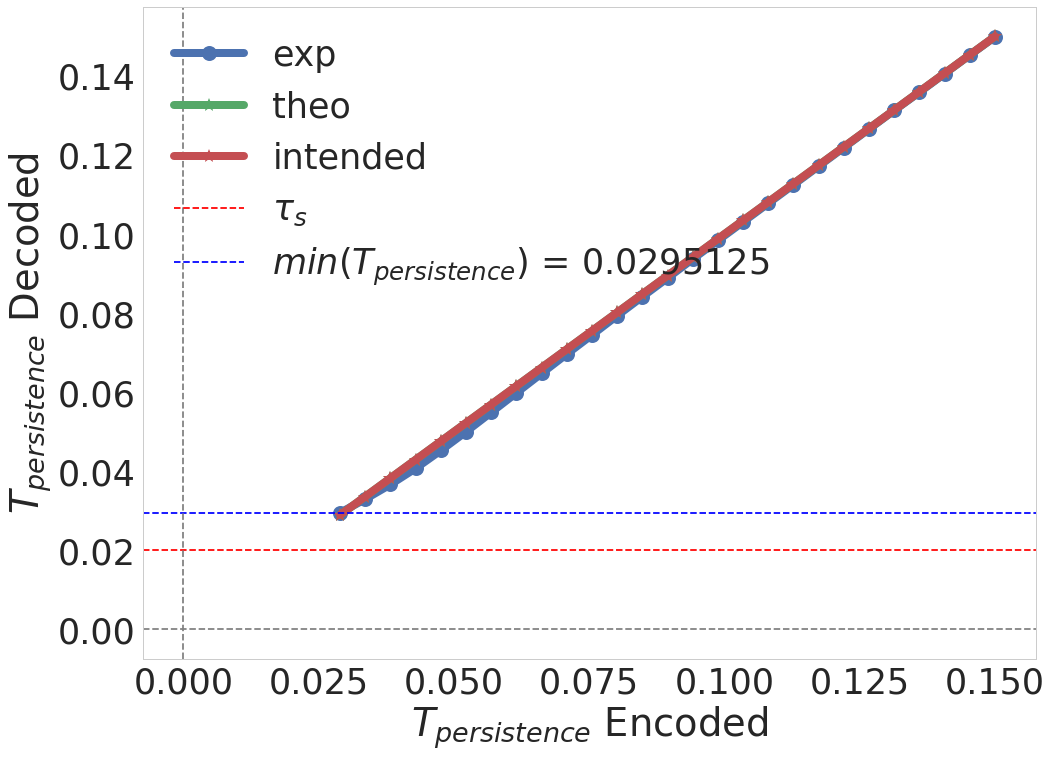

In [10]:
ms = 15
lw = 8

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
colors = sns.color_palette()

index = 0

ax.plot(T_persistence_vector[success > 0], measured_T[success > 0], 'o-', color=colors[index], ms=ms, lw=lw,
        label='exp')
ax.plot(T_persistence_vector[success > 0], T_theo[success > 0], '*-', color=colors[index + 1],
        ms=ms, lw=lw, label='theo')
ax.plot(T_persistence_vector[success > 0], T_persistence_vector[success > 0], '*-', color=colors[index + 2],
        ms=ms, lw=lw, label='intended')

ax.set_xlabel(r'$T_{persistence}$ Encoded')
ax.set_ylabel(r'$T_{persistence}$ Decoded')
ax.axhline(tau_m, ls='--', color='red', label=r'$\tau_s$')
min_t = min(measured_T[success > 0]) 
ax.axhline(min_t, ls='--', color='blue', label=r'$min(T_{persistence})$ = ' + str(min_t))
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')
ax.legend();

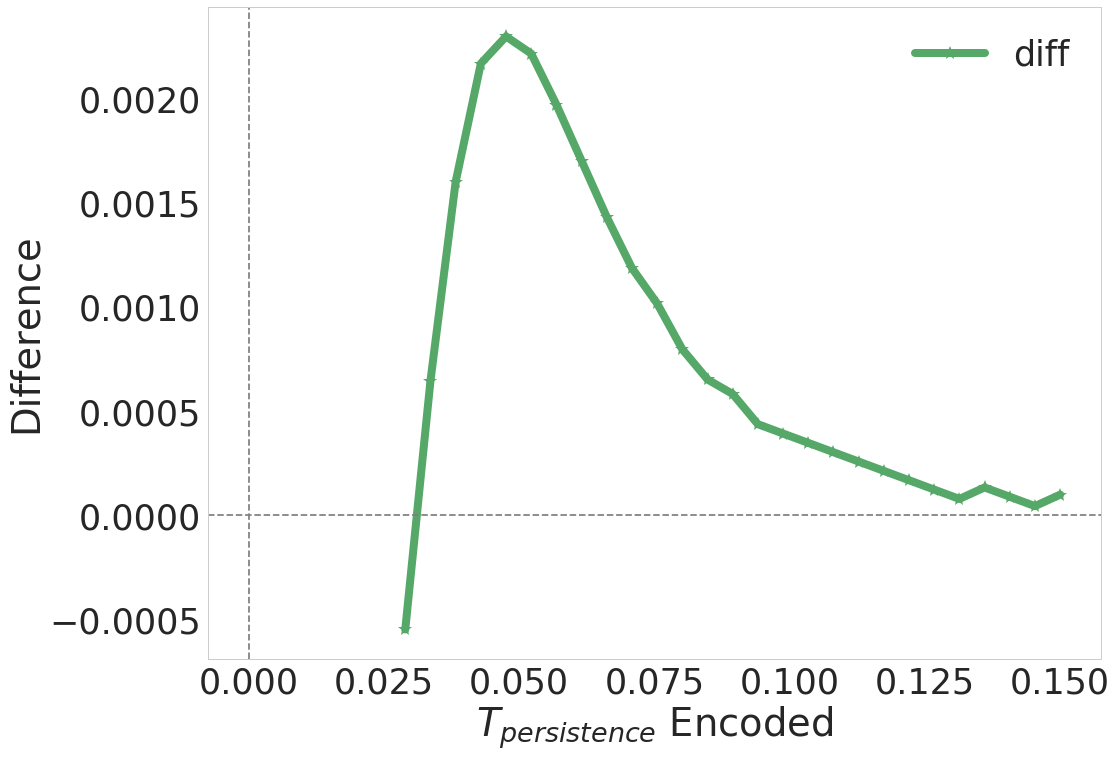

In [11]:
ms = 15
lw = 8

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
colors = sns.color_palette()

index = 0
ax.plot(T_persistence_vector[success > 0], T_persistence_vector[success > 0] - measured_T[success > 0], '*-', color=colors[index + 1],
        ms=ms, lw=lw, label='diff')

ax.set_xlabel(r'$T_{persistence}$ Encoded')
ax.set_ylabel(r'Difference')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')
ax.legend();

#### The encoding works beautifully. Not it does not

## Compare the encodings

In [12]:
%%time

always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
g_beta = 0.0
tau_a = 0.150
G = 1.0
sigma = 0.0
tau_m = 0.010
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.0001
values_to_save = ['o']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

# Recall
T_cue = 0.020
T_recall = 1.0 + T_cue
n = 1
remove = 0.010

num = 25
T_persistence_vector = np.linspace(0.010, 0.100, num=num)

measured_T_1 = np.zeros(num)
measured_T_2  = np.zeros(num)
measured_T_3 = np.zeros(num)

T_theo_T_1 = np.zeros(num)
T_theo_T_2 = np.zeros(num)
T_theo_T_3 = np.zeros(num)

T_theo_s_1 = np.zeros(num)
T_theo_s_2 = np.zeros(num)
T_theo_s_3 = np.zeros(num)

success1 = np.zeros(num)
success2 = np.zeros(num)
success3 = np.zeros(num)


# Neural Network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m, 
                  g_beta=g_beta, sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, 
                  tau_p=tau_p, z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
seq = matrix[:n_patterns]
nr = build_network_representation(seq, minicolumns, hypercolumns)

aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
manager.patterns_dic = patterns_dic

for index, T_persistence in enumerate(T_persistence_vector):
    T_recall = 1.5 * n_patterns * T_persistence + T_cue
    n_connections = len(seq) - 1
    value = 1.0
    extension = 3
    r = tau_m / tau_a
    f = 1 - r
    correction = (r / f) * np.exp(-T_persistence / tau_m)
    B1 = 1 - np.exp(-T_persistence / tau_a)
    B2 = 1 - (1/f) * np.exp(-T_persistence / tau_a) 
    B3 = B2 + correction

    w_min = -10
    weights = [value for i in range(n_connections)]
    weights_collection = [weights]
    sequences = [seq]
  
    w1 = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                    extension, B1, w_min=w_min)
    w2 = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                extension, B2, w_min=w_min)
    w3 = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                extension, B3, w_min=w_min)

    
    nn.w_ampa = w1
    aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=remove)
    s, timings, pattern_sequence = aux
    times = [t[1] for t in timings[1:n_patterns - 1]]
    T_mean = np.mean(times)
    measured_T_1[index] = T_mean
    w_tran = B1
    T_theo_T_1[index] = calculate_T_persistence(tau_a, g_w_ampa, w_tran, g_a, tau_m, perfect=perfect)
    T_theo_s_1[index] = calculate_T_persistence(tau_a, g_w_ampa, w_tran, g_a, tau_m, perfect=False) + tau_m
    success1[index] = s
        
    nn.w_ampa = w2
    aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=remove)
    s, timings, pattern_sequence = aux
    times = [t[1] for t in timings[1:n_patterns - 1]]
    T_mean = np.mean(times)
    measured_T_2[index] = T_mean
    w_tran = B2 
    T_theo_T_2[index] = calculate_T_persistence(tau_a, g_w_ampa, w_tran, g_a, tau_m, perfect=perfect)
    T_theo_s_2[index] = calculate_T_persistence(tau_a, g_w_ampa, w_tran, g_a, tau_m, perfect=False) + tau_m
    success2[index] = s
    
    nn.w_ampa = w3
    aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=remove)
    s, timings, pattern_sequence = aux
    times = [t[1] for t in timings[1:n_patterns - 1]]
    T_mean = np.mean(times)
    measured_T_3[index] = T_mean
    w_tran = B3 
    T_theo_T_3[index] = calculate_T_persistence(tau_a, g_w_ampa, w_tran, g_a, tau_m, perfect=perfect)
    T_theo_s_3[index] = calculate_T_persistence(tau_a, g_w_ampa, w_tran, g_a, tau_m, perfect=False) + tau_m
    success3[index] = s

CPU times: user 2min 4s, sys: 136 ms, total: 2min 4s
Wall time: 2min 4s


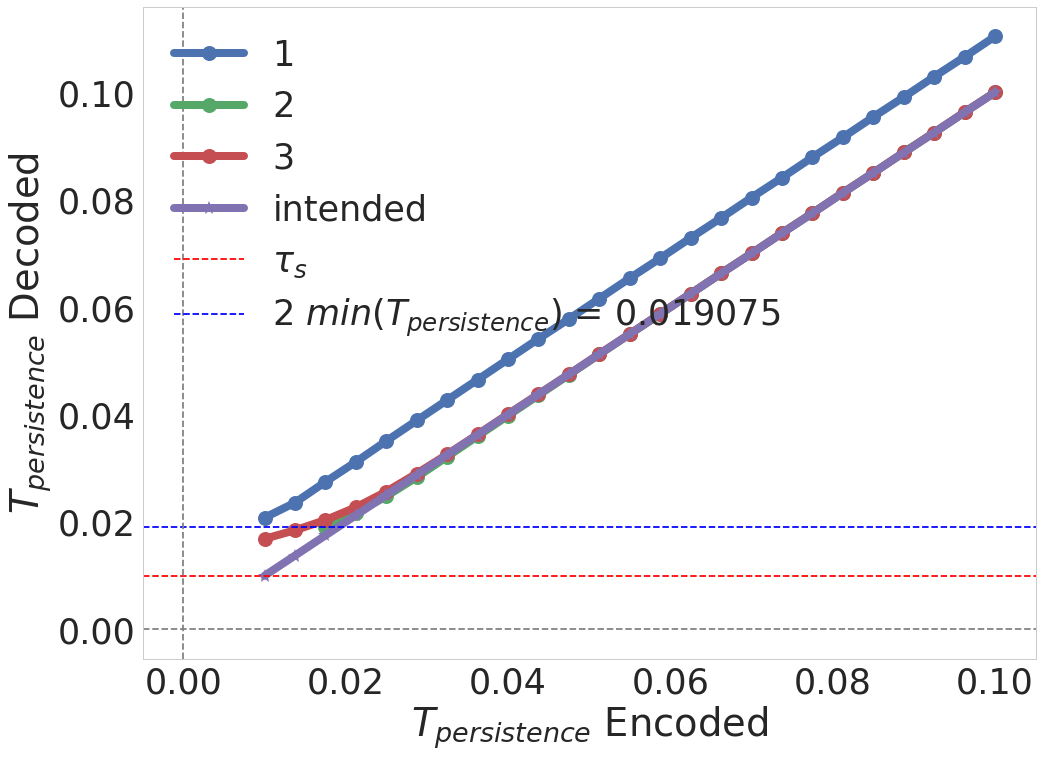

In [13]:
ms = 15
lw = 8

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
colors = sns.color_palette()

index = 0

ax.plot(T_persistence_vector[success1 > 0], measured_T_1[success1 > 0], 'o-', ms=ms, lw=lw,
        label='1')
ax.plot(T_persistence_vector[success2 > 0], measured_T_2[success2 > 0], 'o-', ms=ms, lw=lw,
        label='2')
ax.plot(T_persistence_vector[success3 > 0], measured_T_3[success3 > 0], 'o-', ms=ms, lw=lw,
        label='3')
ax.plot(T_persistence_vector, T_persistence_vector, '*-', ms=ms, lw=lw, label='intended')

ax.set_xlabel(r'$T_{persistence}$ Encoded')
ax.set_ylabel(r'$T_{persistence}$ Decoded')
ax.axhline(tau_m, ls='--', color='red', label=r'$\tau_s$')
min_t = min(measured_T_2[success2 > 0]) 
ax.axhline(min_t, ls='--', color='blue', label=r'2 $min(T_{persistence})$ = ' + str(min_t))
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')
ax.legend();

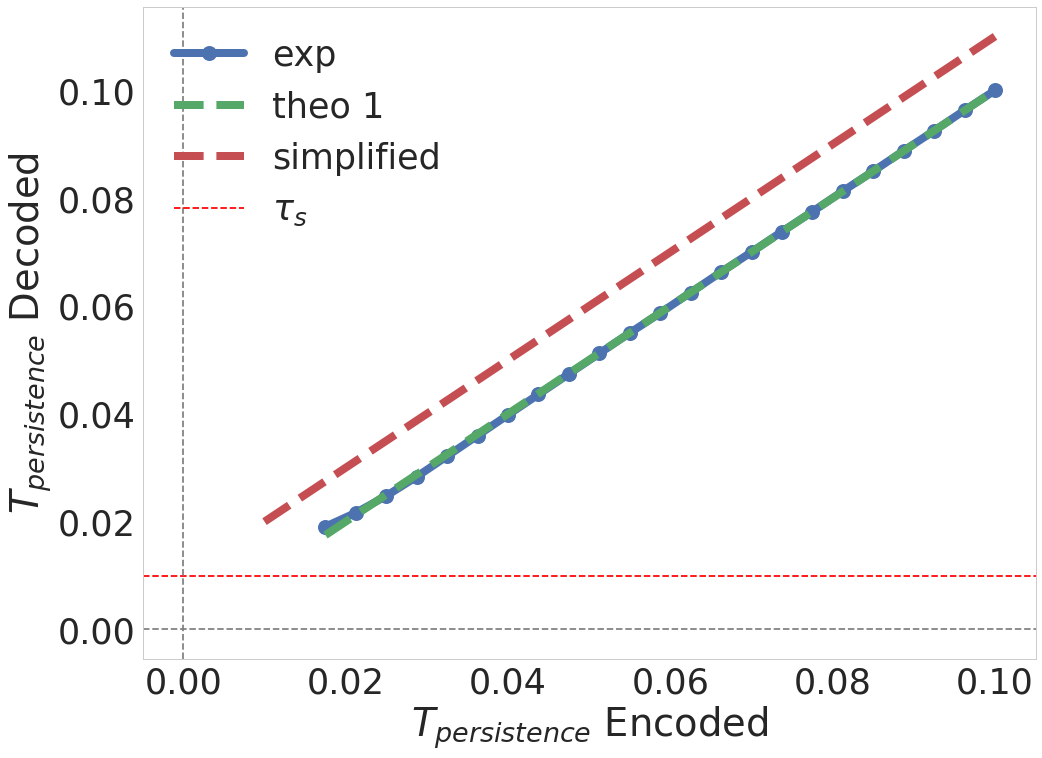

In [14]:
ms = 15
lw = 8

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
colors = sns.color_palette()

ax.plot(T_persistence_vector[success2 > 0], measured_T_2[success2 > 0], 'o-', ms=ms, lw=lw,
        label='exp')
ax.plot(T_persistence_vector[success2 > 0], T_theo_T_2[success2 > 0], '--', ms=ms, lw=lw,
        label='theo 1')
ax.plot(T_persistence_vector[success3 > 0], T_theo_s_2[success3 > 0], '--', ms=ms, lw=lw,
        label='simplified')
#ax.plot(T_persistence_vector, T_persistence_vector, '*-', ms=ms, lw=lw, label='intended')


ax.set_xlabel(r'$T_{persistence}$ Encoded')
ax.set_ylabel(r'$T_{persistence}$ Decoded')
ax.axhline(tau_m, ls='--', color='red', label=r'$\tau_s$')
#min_t = min(measured_T[success > 0]) 
#ax.axhline(min_t, ls='--', color='blue', label=r'$min(T_{persistence})$ = ' + str(min_t))
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')
ax.legend();

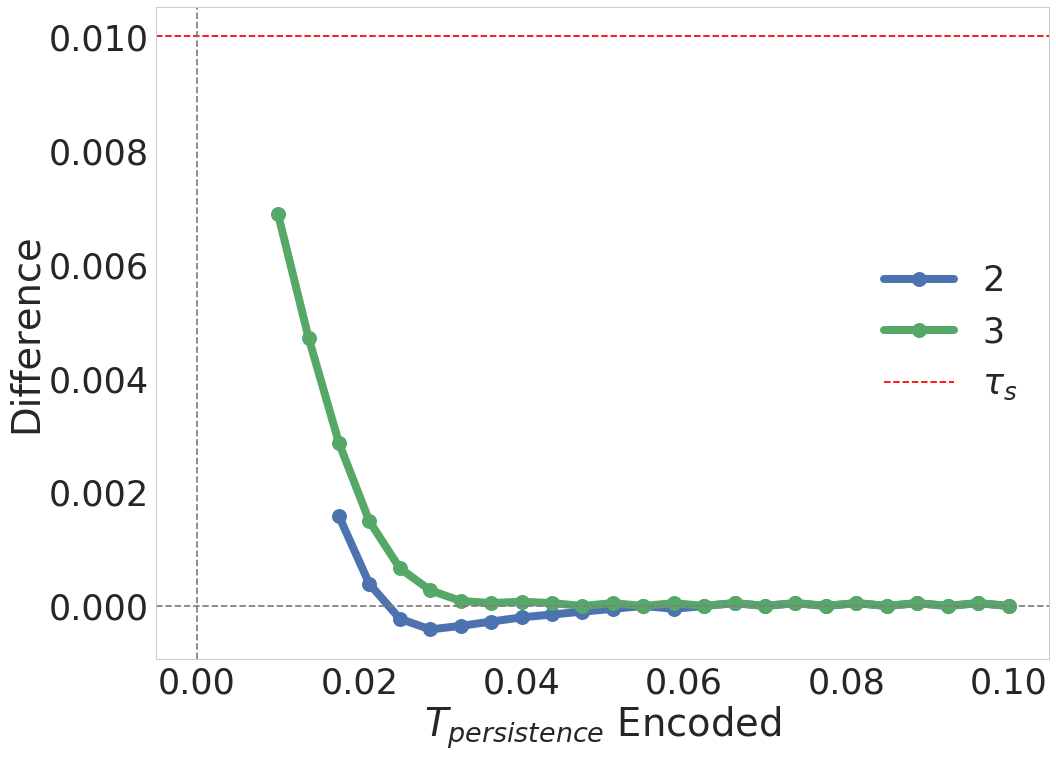

In [15]:
ms = 15
lw = 8

fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
colors = sns.color_palette()

index = 0

ax.plot(T_persistence_vector[success2 > 0], measured_T_2[success2 > 0 ] - T_persistence_vector[success2 > 0], 'o-', ms=ms, lw=lw,
        label='2')
ax.plot(T_persistence_vector[success3 > 0], measured_T_3[success3 > 0] - T_persistence_vector[success3 > 0], 'o-', ms=ms, lw=lw,
        label='3')

ax.set_xlabel(r'$T_{persistence}$ Encoded')
ax.set_ylabel(r'Difference')
ax.axhline(tau_m, ls='--', color='red', label=r'$\tau_s$')
ax.axhline(0, ls='--', color='gray')
ax.axvline(0, ls='--', color='gray')
ax.legend();

Observations:
* It seems that the second enconding is the best, it does not encode succesfully for values lower than 20ms when tau_m=20ms but it always encodes correctly. The others can encode succesfully for lower valures but they do not encode correctly.
* I had a tau_a = 150ms and it was not enough to learn patterns with T_per of less than 20ms.
* Decreasing tau_m = 10, did help encoding patterns closer to that duration. I will use that one now.

## Noise with and without tau_m

In [16]:
%%time
always_learning = False
strict_maximum = True
perfect = False
z_transfer = False
k_perfect = True
diagonal_zero = False
normalized_currents = True

g_w_ampa = 1.0
g_w = 0.0
g_a = 1.0
g_beta = 0.0
tau_a = 0.100
G = 1.0
sigma = 0.0
tau_m = 0.020
tau_z_pre_ampa = 0.025
tau_z_post_ampa = 0.005
tau_p = 10.0

hypercolumns = 1
minicolumns = 10
n_patterns = 10

# Manager properties
dt = 0.001
values_to_save = ['o', 's', 'i_ampa', 'a']

# Protocol
training_time = 0.100
inter_sequence_interval = 0.0
inter_pulse_interval = 0.0
resting_time = 2.0
epochs = 1

# Recall
T_cue = 0.020
T_recall = 1.0 + T_cue
remove = 0.010

# Neural Network
nn = BCPNNPerfect(hypercolumns, minicolumns, g_w_ampa=g_w_ampa, g_w=g_w, g_a=g_a, tau_a=tau_a, tau_m=tau_m,
                  sigma=sigma, G=G, tau_z_pre_ampa=tau_z_pre_ampa, tau_z_post_ampa=tau_z_post_ampa, tau_p=tau_p,
                  z_transfer=z_transfer, diagonal_zero=diagonal_zero, strict_maximum=strict_maximum, 
                  perfect=perfect, k_perfect=k_perfect, always_learning=always_learning, 
                  normalized_currents=normalized_currents)

# Build the manager
manager = NetworkManager(nn=nn, dt=dt, values_to_save=values_to_save)

# Protocol
matrix = create_orthogonal_canonical_representation(minicolumns, hypercolumns)
seq = matrix[:n_patterns]
nr = build_network_representation(seq, minicolumns, hypercolumns)

n_connections = len(seq) - 1
value = 1.0
extension = 3
alpha = 0.5
weights = [value for i in range(n_connections)]
weights_collection = [weights]
sequences = [seq]
w = create_matrix_from_sequences_representation(minicolumns, hypercolumns, sequences, weights_collection,
                                                extension, alpha, w_min=-10.0)

nn.w_ampa = w
aux, indexes = np.unique(nr, axis=0, return_index=True)
patterns_dic = {index:pattern for (index, pattern) in zip(indexes, aux)}
manager.patterns_dic = patterns_dic

num = 30
trials = 25
sigma_vector = np.linspace(0, 2.0, num=num)
successes = np.zeros((num, trials))
successes_m = np.zeros((num, trials))
persistence_times = np.zeros((num, trials, n_patterns - 2))
persistence_times_m = np.zeros((num, trials, n_patterns - 2))

for sigma_index, sigma in enumerate(sigma_vector):
    for trial_index in range(trials):
        nn.perfect = True
        nn.sigma = sigma
        aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=remove)
        s, timings, pattern_sequence = aux
        T_persistence = [t[1] for t in timings[1:-1]]
        successes[sigma_index, trial_index] = s
        n_aux = min((len(T_persistence), n_patterns - 2))
        persistence_times[sigma_index, trial_index, :n_aux] = np.array(T_persistence)[:n_aux]
        
        nn.perfect = False
        aux = calculate_recall_success_nr(manager, nr, T_recall, T_cue, debug=True, remove=remove)
        s, timings, pattern_sequence = aux
        T_persistence = [t[1] for t in timings[1:-1]]
        successes_m[sigma_index, trial_index] = s
        n_aux = min((len(T_persistence), n_patterns - 2))
        persistence_times_m[sigma_index, trial_index, :n_aux] = np.array(T_persistence)[:n_aux]

CPU times: user 5min 24s, sys: 132 ms, total: 5min 24s
Wall time: 5min 24s


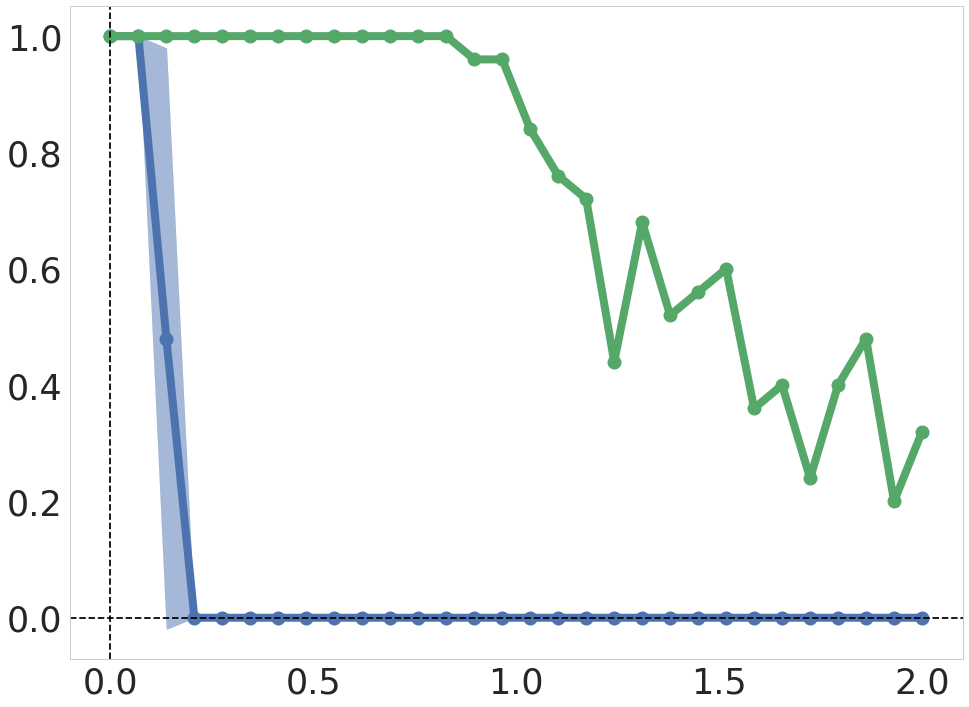

In [17]:
current_palette = sns.color_palette()
index = 0
ms = 14
lw = 8

mean_success = np.mean(successes, axis=1)
mean_success_m = np.mean(successes_m, axis=1)

std = np.std(successes, axis=1)
std_m = np.std(successes_m, axis=1)


fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
ax.plot(sigma_vector, mean_success, 'o-', color=current_palette[index], lw=lw, ms=ms)
ax.plot(sigma_vector, mean_success_m, 'o-', color=current_palette[index + 1], lw=lw, ms=ms)

ax.fill_between(sigma_vector, mean_success - std, mean_success + std,
                color=current_palette[index], alpha=alpha)

ax.axhline(0, ls='--', color='black')
ax.axvline(0, ls='--', color='black');

In [18]:
mean_success

array([ 1.  ,  1.  ,  0.48,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ])